# FYS-STK4155 - Project 2 - Logistic Regression and Neural Network 

In [123]:
import pandas as pd
import os
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score 

## Importing Credit Card Data

In [125]:
def getData():
    cwd = os.getcwd()  #getting the path of this current program
    filename = cwd + '/default of credit card clients.xls'  #path + file
    
    np.random.seed(0)
    #Read file into pandas dataframe 
    nanDict= {}
    df = pd.read_excel('default of credit card clients.xls', header=1, skiprows=0, index_col=0, na_values=nanDict)
    df.rename(index=str, columns={'default payment next month': 'defaultPaymentNextMonth'}, inplace=True)
    
    #Drop the rows including data where parameters are out of range
    df=df.drop(df[df.SEX<1].index)
    df=df.drop(df[df.SEX<2].index)
    df=df.drop(df[(df.EDUCATION <1)].index)
    df=df.drop(df[(df.EDUCATION >4)].index)
    df=df.drop(df[df.MARRIAGE<1].index)
    df=df.drop(df[df.MARRIAGE>3].index)

    #Drop the rows for the customers that do not have any bills & corresponding payments throughout the period 
    #as we do not want the model to train on this data
    df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0) &
                (df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)

    #Features (X) and targets (y):
    #Divide features into categorical and continous data
    X_categorical = df.iloc[:,[1,2,3,5,6,7,8,9,10]].values.copy()
    X_continous = df.iloc[:,[0,4,11,12,13,14,15,16,17,18,19,20,21,22]].values.copy()
    
    y= df.loc[:, df.columns == 'defaultPaymentNextMonth'].values.copy()
    

    #OneHot encoder for categorial data -> [sex,education,marriage, pay_april, pay_may, pay_jun, pay_jul, pay_aug, pay_sep]
    onehotencoder = OneHotEncoder(categories="auto")
    X_categorical = ColumnTransformer([('onehotencoder', onehotencoder, [0,1,2,3,4,5,6,7,8]),],remainder="passthrough").fit_transform(X_categorical).todense()
    y = np.ravel(y)
    
    return X_categorical, X_continous, np.ravel(y), df

## Exploring the balance of the output classes

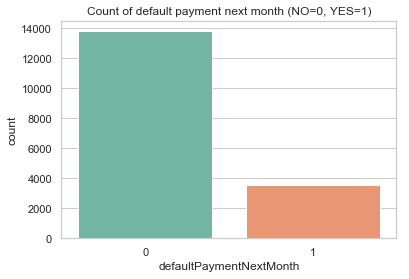

percentage of no default payment (NO=0) is 79.45394850527043
percentage of default payment (YES=1) is 20.546051494729568


In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
#plot
X_cat,X_con ,y, df = getData()
sns.set(style="white")
sns.set(style="whitegrid")
sns.countplot(x='defaultPaymentNextMonth',data=df, palette='Set2')
plt.title('Count of default payment next month (NO=0, YES=1)')
plt.savefig('counter_plot_balance.png', dpi=300)
plt.show()

#percentage calculation 
count_no_default = len(df[df['defaultPaymentNextMonth']==0])
count_default = len(df[df['defaultPaymentNextMonth']==1])
pct_of_no_default = count_no_default/(count_no_default+count_default)
print("percentage of no default payment (NO=0) is", pct_of_no_default*100)
pct_of_default = count_default/(count_no_default+count_default)
print("percentage of default payment (YES=1) is", pct_of_default*100)

## Fixing the imbalance in the data, scale and split into train and test data

In [127]:
X_categorical,X_continous,y,df = getData()

#Fix the imbalance in the data 
ones_  = np.argwhere(y==1).flatten()
zeros_ = np.argwhere(y==0).flatten()

indexes = np.random.choice(zeros_,size=ones_.shape[0]) #randomly choose a no. of target points == 0, corresponding to no. of target points ==1
indexes = np.concatenate((indexes,ones_),axis=0)

y             = y[indexes]
X_categorical = X_categorical[indexes]
X_continous   = X_continous[indexes]
indexes       = np.arange(y.shape[0])

np.random.shuffle(indexes)
y             = y[indexes]
X_categorical = X_categorical[indexes]
X_continous   = X_continous[indexes]
X_continous   = np.array(X_continous)
X_categorical = np.array(X_categorical)


#Train-Test Split - Dividing into Train and Validation(test) data 80:20
trainingShare = 0.8 
seed = 1
X_train_cat, X_test_cat, X_train_con, X_test_con, y_train, y_test=train_test_split(X_categorical, X_continous, y, 
                                              test_size = 1-trainingShare,
                                              random_state=seed,shuffle=True)

#Input Scaling 
sc          = StandardScaler() 
X_train_con = sc.fit_transform(X_train_con)
X_test_con  = sc.transform(X_test_con)


#Reunite the categorical and contonous data in the test and validation(test) data
X_train = np.zeros((X_train_con.shape[0],X_train_con.shape[1] + X_train_cat.shape[1]))
X_test  = np.zeros((X_test_con.shape[0],X_test_con.shape[1] + X_test_cat.shape[1]))


X_train[: , X_train_con.shape[1]:] = X_train_cat
X_train[:,:X_train_con.shape[1]]   = X_train_con

X_test[:,:X_test_con.shape[1]] = X_test_con
X_test[:,X_test_con.shape[1]:] = X_test_cat

## Accuracy evaluation 
- For bianry classification we calculate the accuracy score & confusion matrix.
- For linear regression we calculate MSE and R2 score.

In [128]:
def accuracy_function(y_data, y_pred):  #hvor bra modellen gjor det.
    if np.shape(y_data)[0] == np.shape(y_pred)[0]:
        I = np.mean(y_data==y_pred)     ## =1 if y==y, 0 else.... np.mean #dobbelsjekk at det funker
    else:
        raise ValueError
    return I

def accuracy_matrix(y_data, y_pred, title):
    fig, ax = plt.subplots()
    cm = confusion_matrix(y_data, y_pred)
    print("confusion matrix")
    print(cm)
    cmap = plt.cm.Blues
    im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks = np.arange(cm.shape[1]),
            yticks = np.arange(cm.shape[0]),
            title=title,
            xlabel='predicted target value',
            ylabel='true target value')
    plt.savefig('Confusion_Matrix_{}.png'.format(title), dpi=300)
    plt.show()

    return cm


def MSE_func(y_data, y_pred): #for regression analysis
    return np.mean((y_data - y_pred)**2)

# Logistic Regression 

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from random import random, seed

import numpy as np
import matplotlib.pyplot as plt
 

class LogisticRegression_class:

    def __init__(self, learning_rate, batch_size, n_epochs):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs


    def sigmoid_function(self,x):      #activation function; gives output 0 or 1. 
        return(1/(1+np.exp(-x)))

    def gradient_descent(self, X, y,X_val,y_val):   #optimizing parameters beta
        #y = y[:, np.newaxis] 
        param = np.shape(X)[1]                      #number of parameters
        n = np.shape(X)[0]                          #number of rows
        n_batches = n // self.batch_size            #integer division
        np.random.seed(42)
        beta = np.random.uniform(0.0,1.0, param)    #np.random.randn(param)  #generate random initial values for beta


        error = []
        error_val = []
        #n_0_list = []
        #n_1 = np.count_nonzero(y)   #total number of y=1. double check that those are really 1.
        #const = (n - n_1)/n_1
        #print("*",X.shape, y.shape)
        
        index = np.arange(n)
        np.random.shuffle(index)
        batch_split = np.array_split(index,n_batches)
        
        
        k = 0
        #total numer of iterations:
        for i in range(self.n_epochs):
            y_pred = self.sigmoid_function(X @ beta)
            y_pred_val = self.sigmoid_function(X_val@beta)
            C = self.cost_function(y, y_pred)
            C_val = self.cost_function(y_val,y_pred_val)
            error.append(C)
            error_val.append(C_val)

            for j in batch_split:
                gradient = np.sum ( X[j].T* (self.sigmoid_function(X[j]@beta)- y[j]),axis=1)
                gradient = gradient/y[j].shape[0]
                #learning_rate = self.learning_schedule(i*n_batches+j)     #adaptive learning rate. Sjekke om det enkelste funker forst.
                beta -= self.learning_rate * gradient
                k += 1
        
       
        self.beta = beta
        y_pred = self.sigmoid_function(X @ self.beta)
        tol = 0.5
        y_pred[y_pred >= tol] = 1
        y_pred[y_pred < tol] = 0
        y_pred_val[y_pred_val >= tol] = 1
        y_pred_val[y_pred_val < tol] = 0
        return error, error_val, y_pred, y_pred_val

    def fit_function(self, X_train, X_test, y_train, y_test):
        self.gradient_descent(X_train, y_train)
        y_pred = X_test @ self.beta
        
        
        
    #Scikit-Learn LogisticRegression
    def predict_sklearn(self, X_train, X_test, y_train, y_test):
        LR = LogisticRegression(solver='lbfgs', max_iter=400)
        LR.fit(X_train,y_train)
        y_pred = LR.predict(X_test)
        return y_pred         

    def cost_function(self, y_data, y_pred):  #oppdatere parametrene.
        cost = -np.mean( (y_data.T * y_pred ) - np.log(1+np.exp(y_pred)))
        return cost
    
    
   

## Running Logistic regression for self written code & Scikit-Learn

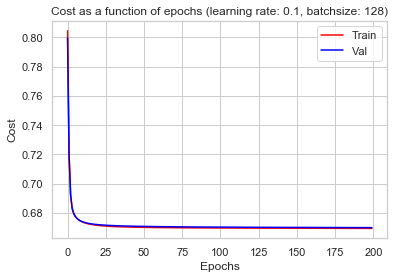

In [130]:
lr = 1e-1
n_epochs = 200
batch_size = 128
LogReg = LogisticRegression_class(lr, batch_size, n_epochs)
error_train,error_val, y_pred, y_val = LogReg.gradient_descent(X_train, y_train, X_test, y_test)
y_skl_val = LogReg.predict_sklearn(X_train, X_test, y_train, y_test)


#Plot cost function with stochastic gradient descent. 
plt.plot(range(n_epochs), error_train,label='Train', color='red')
plt.plot(range(n_epochs),error_val,label='Val', color='blue')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost as a function of epochs (learning rate: {}, batchsize: {})'.format(lr, batch_size))
plt.savefig('cost_func.png', dpi=300)
plt.show()

Accuracy score - Train:  0.7256001401787279
confusion matrix
[[2426  435]
 [1178 1668]]


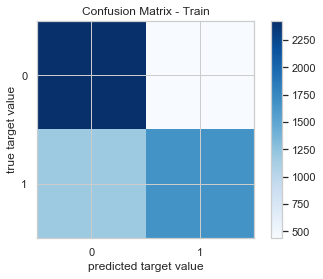

Accuracy score - Validation:  0.7014716187806588
confusion matrix
[[590 116]
 [305 416]]


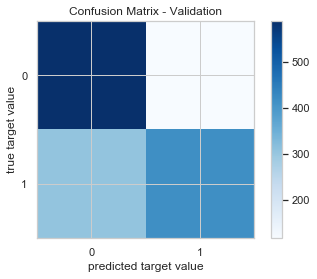

Accuracy score - Scikit-Learn:  0.7021723896285914
confusion matrix
[[591 115]
 [310 411]]


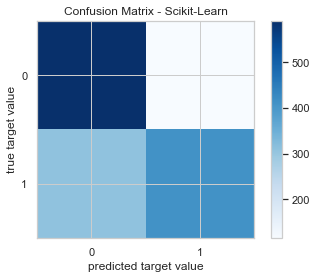

In [131]:
#Accuracy score and  confusion matrix
#Training data
print("Accuracy score - Train: ",score_train)
score_train = accuracy_score(y_train, y_pred)
CM_train = accuracy_matrix(y_train, y_pred, 'Confusion Matrix - Train' )

#Validation Data
print("Accuracy score - Validation: ",score_val)
score_val = accuracy_score(y_test, y_val)
CM_train = accuracy_matrix(y_test, y_val, 'Confusion Matrix - Validation' )

#Scikit-Learn
print("Accuracy score - Scikit-Learn: ", score_sk_val)
score_sk_val = accuracy_score(y_test, y_skl_val)
CM_train = accuracy_matrix(y_test, y_skl_val, 'Confusion Matrix - Scikit-Learn' )

# Cost and Activation functions
Cost functions: 
- negative log
- Mean Squared Error

Activation functions:
- hyperbolic tangent
- sigmoid
- rectified linear unit

In [132]:
#Cost functions
def neg_log(y_data, y_pred,deriv=False):
    y_pred = y_pred.reshape(y_pred.shape[0],1)
    y_data = y_data.reshape(y_data.shape[0],1)
    if deriv:
        return(y_pred - y_data)
    else:
        return -np.mean( (y_data.T * y_pred) - np.log(1+np.exp(y_pred)))
    
def MSE(y_data, y_pred, deriv=False):
    if deriv:
        y_pred = y_pred.reshape(y_pred.shape[0],1)
        y_data = y_data.reshape(y_data.shape[0],1) 
        return(np.mean(2*(y_pred-y_data)))
    else:
        return(np.mean((y_data-y_pred)**2))
    
    

#Activation functions
def tanh(x, deriv=False):
    if deriv:
        tanh = (np.exp(2*x)-1)/(np.exp(2*x)+1)    
        return(1-tanh**2)
    else:
        return(np.exp(2*x)-1)/(np.exp(2*x)+1)    
    

def sigmoid_function(x,deriv=False):
    if deriv:
        sig = 1/(1 + np.exp(-x))
        return(sig*(1 - sig))
    else:
        return(1/(1+np.exp(-x)))
    
    
def ReLu(x, deriv=False):
    if deriv:
        ReLu = np.maximum(0,x)
        return((x>0)*1)
    else:
        return(np.maximum(0,x))


# Neural Network
Full code - self written Neural Network

In [133]:
#Produce layers for the neural network, no. of layers are chosen in NeuralNetwork class
#class Dense initialize weights and biases for every layer, and returns the weighted sum. 
class Dense:
    def __init__(self,n_inputs,n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.w = np.random.randn(self.n_inputs,self.n_outputs)*np.sqrt(1/(n_inputs+n_outputs)) #initialize for at verdiene ikke skal skli ut til ytterpunktene men holde seg paa midten
        self.b = np.zeros((1,self.n_outputs)) + 0.01
        
    def __call__(self,x):
        self.output = x@self.w + self.b
        return(self.output)


class NeuralNetwork:
    def __init__(self,layers, n_inputs, n_outputs, activation_function, cost_function):
        self.n_inputs         = n_inputs            #Initial X parameters from the data set 
        self.n_outputs        = n_outputs           #Outputs in final layer
    
        self.act_func         = activation_function #activation function
        self.cost_func        = cost_function       #cost function
        
        self.layers = [] 
        for i in range(len(layers)):                        #layers: hidden layers, with nodes in eg. [10,20]
            self.layers.append(Dense(n_inputs,layers[i]))   #layers[i]=output for current layer
            n_inputs = layers[i]                            #n_inputs update --> last layer output is new input
        self.layers.append(Dense(layers[-1],n_outputs))     #last layer appended
        
        
    
    def feed_forward(self,X):
        x = X.copy()
        for i,layer in enumerate(self.layers):            #feed forward by updating current X, and go through activation function 
            x = self.act_func[i](self.layers[i](x))       #X--> a^l-> a^(l+1)-->..--> a^L
        return(x)
        
    
    def backpropagation(self,X,y):
        x = X.copy()
        y_pred = self.feed_forward(x)      #y_pred --> aL = self.feed-forward(x)
        
        delta = self.cost_func(y,y_pred, deriv=True)*self.act_func[-1](self.layers[-1].output, deriv=True) #delta^L --> error in output layer  
        
        
        w_grad = []   
        b_grad = []
        b_grad.append(np.sum(delta,axis=0))          #initial change in cost as function of bias 
        
        w_grad.append((self.act_func[-2](self.layers[-2].output.T@delta)))#initial change in cost as function of weight
       
        
        l = len(self.layers) - 2                      #l = L last hidden layer, from which we propagate backwards
        
        
        #propagating backwards
        for layer in reversed(self.layers[:-1]):
            
            delta = (delta@self.layers[l+1].w.T)*self.act_func[l](self.layers[l].output,deriv=True) #delta^l -->(l=L-i) error in hidden layer i
            b_grad.append(np.sum(delta,axis=0))#fetching beta_gradient 
            
            if l==0:
                a = x.T
                grad = a@delta
            else:
                a = self.act_func[l-1](self.layers[l-1].output)
                grad = a.T@delta
            
            w_grad.append(grad)                #fetchings weight_gradient
            l-=1
        
            
        w_grad = list(reversed(w_grad))                         #Revers list so it starts at input
        b_grad = list(reversed(b_grad))
        
        return(w_grad,b_grad)
    
    def train(self,X,y,X_test,y_test,lr,batch_size,epochs):
        error = []
        error_test = []
        data_ind = np.arange(X.shape[0])                           #no. of data points
        iterations = int(X.shape[0] / batch_size)                  #no. of iterations
        
        #gradient descent 
        for i in range(epochs):  

            for j in range(iterations):
                #pick datapoints with replacements
                chosen_datapoints = np.random.choice(data_ind, size=batch_size, replace=False)
    
                
                #minibatch data
                X_full = X[chosen_datapoints]
                y_full = y[chosen_datapoints]
            
                w_grad,b_grad = self.backpropagation(X_full,y_full)
                
                for index, layer in enumerate(self.layers): #update gradient descent
                    
                    self.layers[index].w = self.layers[index].w - lr*w_grad[index]/batch_size
                    self.layers[index].b = self.layers[index].b - lr*b_grad[index]/batch_size
                    
            
            y_pred = self.feed_forward(X)
            cost_  = self.cost_func(y,y_pred,deriv=False)
            error.append(cost_)
            
            y_pred_test = self.feed_forward(X_test)
            cost_       = self.cost_func(y_test,y_pred_test,deriv=False)
            error_test.append(cost_)
        return error, error_test

Neural Network from Scikit-Learn

In [134]:
def sklearn_NN(X, y, X_val, y_val, lr):
    from sklearn.neural_network import MLPClassifier
    clf = MLPClassifier(activation='tanh',solver='sgd', alpha=lr, hidden_layer_sizes=(50,50,10), random_state=1,max_iter=1000)
    clf.fit(X, y)    
    y_pred=clf.predict(X)
    y_pred_val = clf.predict(X_val)

    return y_pred,y_pred_val

## Running self written Neural Network

In [135]:
layers    = [50,50,10]  #number of nodes in each hidden layer: [50,50,10] corresponds to three layers with 50, 50 and 10 nodes.
n_inputs  = X_train.shape[1]
n_outputs = 1
activation_function = [tanh,tanh,tanh,sigmoid_function]  #activation function for hidden layers and outputlayer[-1] (always sigmoid in classification binary problems since want outcome specifically 0 or 1) 
#activation_function = [ReLu,ReLu,ReLu,sigmoid_function]
#activation_function = [sigmoid_function,sigmoid_function,sigmoid_function,sigmoid_function]
cost_function = neg_log

lr        = 1e-2
batch_size= 128
epochs    = 200

NN = NeuralNetwork(layers, n_inputs, n_outputs,activation_function, cost_function)
error_train, error_val = NN.train(X_train,y_train,X_test,y_test,lr,batch_size,epochs)

y_pred_val   = NN.feed_forward(X_test) 
y_pred_train = NN.feed_forward(X_train)

tol = 0.5
y_pred_val[y_pred_val >= tol] = 1
y_pred_val[y_pred_val < tol] = 0
y_pred_train[y_pred_train >= tol] = 1
y_pred_train[y_pred_train < tol] = 0
y_pred_train = np.ravel(y_pred_train)

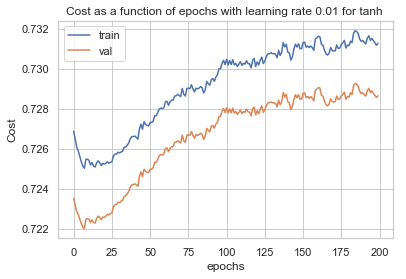

In [136]:
plt.plot(range(epochs), error_train, label='train')
plt.plot(range(epochs), error_val, label='val')
plt.legend()
plt.title('Cost as a function of epochs with learning rate {} for {} '.format(lr, activation_function[0].__name__))
plt.xlabel('epochs')
plt.ylabel('Cost')
plt.savefig('NN_{}_classification_test.png'.format(activation_function[0].__name__), dpi=300)
plt.legend()
plt.show()

Accuracy score - Train: 0.7187664271946732
confusion matrix
[[2391  470]
 [1135 1711]]


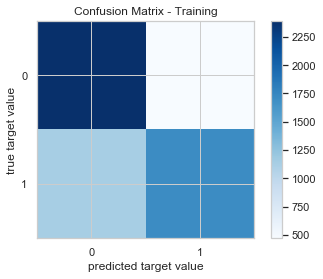

Accuracy score - Validation:  0.4988250916232102
confusion matrix
[[575 131]
 [298 423]]


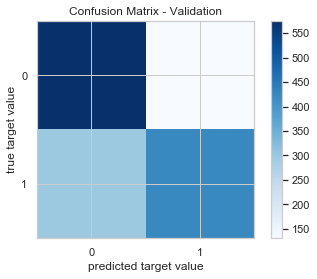

array([[575, 131],
       [298, 423]])

In [154]:
#Accuracy score and confusion matrix 
train_score = accuracy_function(y_train, y_pred_train)
val_score   = accuracy_function(y_test, y_pred_val)

#accuracy_matrix(y_train, y_pred_train, 'NN with learning rate {} and epochs {}.png'.format(lr, epochs))
print("Accuracy score - Train:",train_score)
#accuracy_matrix(y_train, y_pred_train, 'NN-Train with learning_rate_{}_epochs_{}'.format(lr, epochs))
accuracy_matrix(y_train, y_pred_train, 'Confusion Matrix - Training')

print("Accuracy score - Validation: ", val_score)
#accuracy_matrix(y_test, y_pred_val, 'NN-Val with_learning_rate_{}_epochs_{}'.format(lr, epochs))
accuracy_matrix(y_test, y_pred_val, 'Confusion Matrix - Validation')

## Running Neural Network from Scikit-Learn

Accuracy score - Train:  0.7256001401787279
confusion matrix
[[2402  459]
 [1107 1739]]


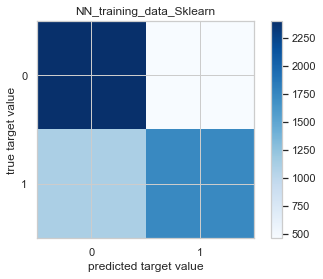

Accuracy score Validation:  0.7014716187806588
confusion matrix
[[572 134]
 [292 429]]


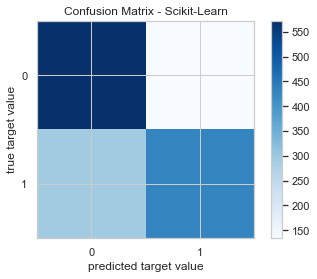

array([[572, 134],
       [292, 429]])

In [155]:
lr =1e-1
y_pred, y_val = sklearn_NN(X_train, y_train, X_test, y_test, lr)

score_train = accuracy_function(y_train, y_pred)
print("Accuracy score - Train: ",score_train)
accuracy_matrix(y_train, y_pred, 'NN_training_data_Sklearn')  # 0.7248


score_test = accuracy_function(y_test, y_val)
print("Accuracy score Validation: ",score_test)
#accuracy_matrix(y_test, y_val, 'NN-scikit_validation_data_Sklearn')
accuracy_matrix(y_test, y_val, 'Confusion Matrix - Scikit-Learn')

# Linear Regression Class 

In [156]:
import numpy as np
from sklearn.linear_model import LinearRegression as OLS, Ridge, Lasso

"""
Default data set: Franke Function.
Change the cost function in order to perform a regression.
We need to find
"""

class Regression:

    def __init__(self, model, lamb, X, z):
        self.model = model
        self.lamb = lamb
        self.X = X
        self.z = z

    def OLS(self):
        self.beta_OLS = np.linalg.pinv(self.X.T.dot(self.X)) @ self.X.T.dot(self.z)

    def Ridge(self):
        n,p=np.shape(self.X)
        I_lambda = np.identity(p, dtype=None)*self.lamb
        self.beta_ridge = np.linalg.inv(self.X.T.dot(self.X) + I_lambda) @ (self.X.T.dot(self.z))

    def Lasso(self):

        self.beta_Lasso = Lasso(alpha=self.lamb, fit_intercept=False,
                normalize=False, max_iter=1000).fit(self.X, self.z).coef_

    def predict(self, X):
        if self.model == 'OLS':
            self.OLS()
            return X @ self.beta_OLS
        elif self.model == 'Ridge':
            self.Ridge()
            #print(self.beta_ridge)
            return X @ self.beta_ridge
        elif self.model == 'Lasso':
            self.Lasso()
            return X @ self.beta_Lasso

    def sklearn_reg(self, X):
        if self.model == 'OLS':
            clf = OLS()
            clf.fit(self.X, self.z)
            y_pred = clf.predict(X)
    
            
        elif self.model == 'Ridge':
            clf = Ridge(alpha=self.lamb)
            clf.fit(self.X, self.z)
            y_pred = clf.predict(X)
            
        elif self.model == 'Lasso':
            clf = Lasso(alpha=self.lamb, max_iter=10000, normalize=False, tol=0.0001)
            clf.fit(self.X, self.z)
            y_pred = clf.predict(X)
        return y_pred

# Franke Function

In [157]:
def Franke_Func(x,y, n=20):   #f(x,y) #France function
    term1 = ( 0.75 * np.exp( -((9*x - 2)**2 / 4)  - ((9*y-2)**2 / 4)) )
    term2 = ( 0.75 * np.exp( -((9*x+1)**2 / 49) - ((9*y+1)**2 / 10 )) )
    term3 = ( 0.5 * np.exp( -((9*x-7)**2 / 4 ) - ((9*y-3)**2 / 4)) )
    term4 = -( 0.2 * np.exp( -(9*x-4)**2 - (9*y-7)**2 ) )
    #noise = np.random.normal(0, 0, n)
    return (term1 + term2 + term3 + term4) #+ noise)


def design_matrix(x, y, deg):

    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    p = int((deg + 1)*(deg + 2)/2)
    X = np.ones((N,p))

    for i in range(1, deg + 1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

/Users/idunnmoatue/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.19847257536597, tolerance: 0.04753447138211052
  positive)
/Users/idunnmoatue/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187.19847257536597, tolerance: 0.04753447138211052
  positive)
/Users/idunnmoatue/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.5224175013448, tolerance: 0.04407837499032965
  positive)
/Users/idunnmoatue/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. Yo

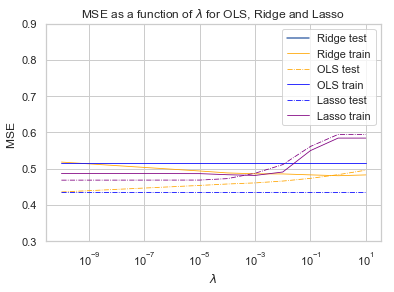

In [158]:
n=1000
#random.seed(2018)
np.random.seed(2018)
x = np.random.random(n)
y = np.random.random(n)
noise = 0.7*np.random.randn(n)   #0.1*np.random.randn(20,1)  #(mu=0, sigma^2=1)
z = Franke_Func(x,y) + noise #f(x,y)+epsilon
X = design_matrix(x,y, 10)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

#lambda_ = np.logspace(-5,0,10)
lambda_ = [1e-10,1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1e0, 1e1]

#from sklearn.metrics import mean_squared_error, r2_score
#print(X_train.shape, X_test.shape, z_train.shape, z_test.shape)

def get_error(lambda_, model):
    list_test_MSE = []
    list_train_MSE = []

    
    for i in range(len(lambda_)):
        lmbd = lambda_[i]
        Reg = Regression(model, lmbd, X_train, z_train)
        z_pred_test = Reg.predict(X_test)
        z_pred_train = Reg.predict(X_train)
        
        z_pred_sklearn_test  = Reg.sklearn_reg(X_test)
        z_pred_sklearn_train  = Reg.sklearn_reg(X_train )       
        
        MSE_test = MSE_func(z_test, z_pred_test)
        MSE_train = MSE_func(z_train, z_pred_train)
        MSE_test_sklearn = MSE_func(z_test, z_pred_sklearn_test)
        MSE_train_sklearn = MSE_func(z_train, z_pred_sklearn_train)
        #print(lambda_[i], model)
        #print("train", "test")
        #print(MSE_train, MSE_test)
        #print(MSE_train_sklearn, MSE_test_sklearn)
        #print("**")

        list_test_MSE.append(MSE_test)
        list_train_MSE.append(MSE_train)
        

    
    return list_test_MSE, list_train_MSE

MSE_test_ridge, MSE_train_ridge = get_error(lambda_, 'Ridge')
MSE_test_ols, MSE_train_ols = get_error(lambda_, 'OLS')
MSE_test_lasso, MSE_train_lasso = get_error(lambda_, 'Lasso')


fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(np.log10(x), y)
plt.plot(lambda_,MSE_test_ridge, color='orange', linewidth=0.8)
plt.plot(lambda_, MSE_train_ridge, '-.', linewidth=0.8, color='orange')
plt.plot(lambda_,MSE_test_ols, color='blue', linewidth=0.8)
plt.plot(lambda_, MSE_train_ols, '-.', linewidth=0.8, color= 'blue')
plt.plot(lambda_,MSE_test_lasso, linewidth = 0.8, color= 'purple')
plt.plot(lambda_, MSE_train_lasso, '-.', linewidth=0.8, color='purple')
plt.legend(['Ridge test', 'Ridge train', 'OLS test', 'OLS train', 'Lasso test', 'Lasso train'], loc='best')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE ')

plt.ylim((0.3,0.9))

plt.title(r'MSE as a function of $\lambda$ for OLS, Ridge and Lasso ')
plt.savefig('MSE_regression.png', dpi =300)
plt.show()

# Neural network on Franke function

In [163]:
layers = [50,50,50]  #number of nodes in each hidden layer: [20,10] corresponds to two layers with 20 and 10 nodes.
n_inputs = X_train.shape[1]
n_outputs = 1

n=1000

#np.random.seed(2018)
x = np.random.random(n)
y = np.random.random(n)
noise = 0.7*np.random.randn(n)   #0.1*np.random.randn(20,1)  #(mu=0, sigma^2=1)
z = Franke_Func(x,y) + noise #f(x,y)+epsilon
X = design_matrix(x,y, 10)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

activation_function = [ReLu,ReLu,ReLu,ReLu]   #setting relu as output layer activation function for 

cost_function = MSE
lr = 1e-1
batch_size= 128
NN_reg = NeuralNetwork(layers, n_inputs, n_outputs, activation_function, cost_function)

epochs=100
error_train, error_val = NN_reg.train(X_train,y_train,X_test,y_test,lr,batch_size,epochs)

"""
plt.plot(range(epochs), error_train, label='train')
plt.plot(range(epochs), error_val, label='val')
plt.show()
"""


def sklearn_NN_regressor(X, y, X_val, y_val, lr):
    
    from sklearn.neural_network import MLPRegressor
    clf = MLPRegressor(activation='relu',solver='sgd', alpha=lr, hidden_layer_sizes=(50,50,10))
    clf.fit(X, y)    
    y_pred=clf.predict(X) 
    y_pred_val = clf.predict(X_val)

    return y_pred_val, y_pred

z_pred_val = NN_reg.feed_forward(X_test)   #calling analytical network
z_pred_train =NN_reg.feed_forward(X_train)



z_pred_sklearn_val,z_pred_sklearn_train = sklearn_NN_regressor(X_train, z_train, X_test, z_test, lr) #scikitlearn NN


z_pred_sklearn_train = np.ravel(z_pred_sklearn_train)
z_pred_sklearn_val = np.ravel(z_pred_sklearn_val)


MSE_train = MSE_func(z_train, z_pred_train)
MSE_test = MSE_func(z_test, z_pred_val)
#print(z_train.shape, z_pred_sklearn_train.shape, z_pred_train.shape)

MSE_train_sklearn = MSE_func(z_train, z_pred_sklearn_train)
MSE_test_sklearn = MSE_func(z_test, z_pred_sklearn_val)



print('MSE - Train:',MSE_train)
print('MSE - Validation:',MSE_test)
print('MSE - ScikitLearn - Train:',MSE_train_sklearn)
print('MSE - ScikitLearn - Validation:',MSE_test_sklearn)

#plt.plot(range(epochs), error_train, label='train data')
#plt.plot(range(epochs), error_val, label='test data')
#plt.legend()
#plt.title('NN on Franke function with ....')
#plt.title('NN on Franke function with {} (learningrate {}, layers {}) '.format(activation_function.__name__[-1], lr, layers))
#plt.xlabel('epochs')
#plt.ylabel('MSE')
#plt.show()


#train_score = accuracy_function(y_train, y_pred_train)
#val_score = accuracy_function(y_test, y_pred_val)
#print("training score: ",train_score, "test score: ", val_score)

#accuracy_matrix(y_train, y_pred_train, 'NN with learning rate {} and epochs {}.png'.format(lr, epochs))
#accuracy_matrix(y_train, y_pred_train, 'train_NN with learning rate {} and epochs {}.png'.format(lr, epochs))
#accuracy_matrix(y_test, y_pred_val, 'test_NN with learning rate {} and epochs {}.png'.format(lr, epochs))

MSE - Train: 0.6424881748652987
MSE - Validation: 0.5622726225010634
MSE - ScikitLearn - Train: 0.5231277582453981
MSE - ScikitLearn - Validation: 0.4662676997427991
